In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.contrib.layers import xavier_initializer
from utils import *
import matplotlib
import matplotlib.pyplot as plt
from IPython.display import clear_output

matplotlib.rc('figure', figsize=(10, 5))

%matplotlib inline

Using TensorFlow backend.


In [70]:
tf.reset_default_graph()

In [2]:
df = pd.read_csv('chembl.csv')

In [3]:
df = df[~pd.isnull(df.acd_logd) & ~pd.isnull(df.acd_logp)]

In [4]:
df['affinity'] = np.zeros(df.shape[0])

In [5]:
def norm(text):
    
    temp = [elems.index(start_elem)] + [elems.index(x) for x in text]
    temp.append(elems.index(end_elem))
    
    return temp

In [6]:
smiles = df.canonical_smiles.apply(norm)

In [7]:
rnn_cell_size = 64
num_layers = 1
embedding_size = 32

split_size = 30
batchsize = 100
epochs = 20
stride=1

num_features = 3

In [71]:
class CharRNN:
    def __init__(self, sess, input_dim, output_dim, embedding_size, rnn_cell_size, num_layers, end_elem, sess_chkpt=''):
        
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.rnn_cell_size = rnn_cell_size
        self.num_layers = num_layers
        self.state_shape =  num_layers*2*rnn_cell_size
        self.end_elem = end_elem
        
        # Main architecrure
        
        self.X = tf.placeholder(tf.float64, shape=[None, None, input_dim])
        
        self.state = tf.placeholder(tf.float64, shape=[None, self.state_shape])
        
        self.lengths = tf.placeholder(tf.float64, shape=[None])
        
        # Embedding
        n_steps = tf.shape(self.X)[1]
        
        flat_X = tf.reshape(self.X, [-1, input_dim])
        
        embedding_matrix = tf.get_variable('Embedding_Matrix', shape=[input_dim, embedding_size], 
                                               initializer=xavier_initializer(), dtype=tf.float64)
        
        embedded = tf.reshape(tf.nn.relu(tf.matmul(flat_X, embedding_matrix)), [-1, n_steps, embedding_size])
        
        # RNN
        rnn_cells = [tf.contrib.rnn.LSTMCell(rnn_cell_size, state_is_tuple=False, initializer=xavier_initializer()) 
                                 for i in range(num_layers)]

        multiple_cells = tf.contrib.rnn.MultiRNNCell(rnn_cells, state_is_tuple=False)

        rnn_output, self.new_state = tf.nn.dynamic_rnn(multiple_cells, embedded, initial_state=self.state, 
                                                       dtype=tf.float64, sequence_length=self.lengths)
        
        # First dense
        
        f_d = tf.layers.dense(rnn_output, rnn_cell_size//2, activation=tf.nn.relu, kernel_initializer=xavier_initializer())
        
        # Output
        
        output_logits = tf.layers.dense(f_d, output_dim, kernel_initializer=xavier_initializer())

        self.output = tf.nn.softmax(output_logits)
        
        # Training utils
        
        self.Y = tf.placeholder(tf.float64, shape=[None, None, output_dim])

        self.loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=output_logits, labels=self.Y))
        
        # Optimizer 
        
        self.optim = tf.train.AdamOptimizer().minimize(self.loss)
        
        # Saver
        
        self.saver = tf.train.Saver()
        
        # Stuff
        
        self.sess = sess
        
        if len(sess_chkpt):
            self.saver.restore(self.sess, sess_chkpt)
        else:
            self.sess.run(tf.global_variables_initializer())

    def train_step(self, X, Y, lengths):
        
        initial_states = np.zeros([len(X), self.state_shape])
        
        feed_dict = {
            self.X: X,
            self.Y: Y,
            self.state: initial_states,
            self.lengths: lengths
        }
        
        _, loss = self.sess.run([self.optim, self.loss], feed_dict=feed_dict)
        
        return loss
    
    def generate_element(self, x, zero_state=True):
        
        if zero_state:
            state = np.zeros([1, self.state_shape])
        else:
            state = self.previous_state
        
        feed_dict = {
            self.X: [x],
            self.state: state,
            self.lengths: [len(x)]
        }
        
        next_element, new_state = self.sess.run([self.output, self.new_state], feed_dict=feed_dict)
        
        self.previous_state = new_state
        
        return next_element
    
    def make_choice(self, probs):
        return np.random.choice(np.arange(self.output_dim), p=probs)
    
    def generate_sequence(self, start, max_len=np.inf):
        
        num_features = self.input_dim - self.output_dim
        
        features = start[0][:num_features]
        
        sequence = [np.argmax(x[num_features:]) for x in start]

        probs = self.generate_element(start, zero_state=True)
        
        next_element = self.make_choice(probs[0][0])

        while next_element != self.end_elem and len(sequence) < max_len:
        
            sequence.append(next_element)
            
            next_input = np.concatenate([features, to_categorical(next_element, self.output_dim)[0]])
            
            probs = self.generate_element([next_input], False)
            
            next_element = self.make_choice(probs[0][0])
            
        return sequence[1:]
    
    def save(self, path):
        self.saver.save(self.sess, path)

In [72]:
sess = tf.Session()

In [73]:
model = CharRNN(sess, len(elems)+num_features, len(elems), embedding_size, rnn_cell_size, num_layers, len(elems)-1)

In [17]:
features = df[["acd_logd", "acd_logp", "affinity"]].values

In [23]:
def prepare_seq(seq, features):
    
    input_raw = to_categorical(seq[:-1], len(elems))
    
    input = np.array([np.concatenate([features, x]) for x in input_raw])
    
    outputs = to_categorical(seq[1:], len(elems))
    
    return input, outputs

def iterate_minibatches(seqs, features, batchsize, shuffle=False):
    
    assert len(seqs) == len(features)
    
    if shuffle:
        indices = np.arange(len(seqs))
        np.random.shuffle(indices)
        
    for start_idx in range(0, len(seqs) - batchsize + 1, batchsize):
        
        if shuffle:
            excerpt = indices[start_idx:start_idx + batchsize]
        else:
            excerpt = slice(start_idx, start_idx + batchsize)
        
        lengths = list(map(lambda x: len(x)-1, seqs[excerpt]))
        
        our_seqs = pad_sequences(seqs[excerpt], padding='post')
        
        X, Y = zip(*map(lambda x: prepare_seq(x[0], x[1]), zip(*[our_seqs, features[excerpt]])))
        
        yield np.array(X), np.array(Y), np.array(lengths)

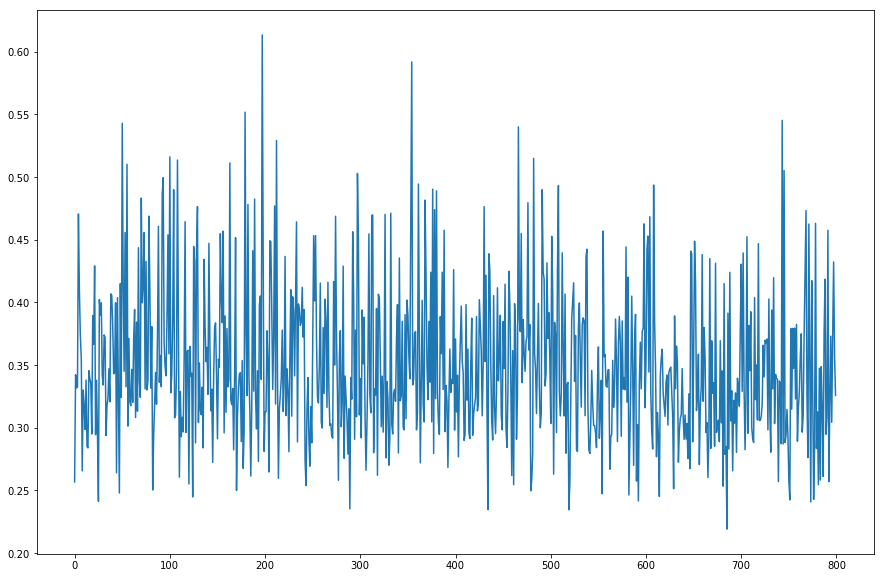

Sample:  Cn1cc(O)cc1C
Sample:  C=C(C1=C=C(c2ccccc2N3)C(=O)[C@@H](Cc4ccccc5c2)N4C[C@@H]3C(=O)O
Sample:  Fc1ccc(Cl)c(Cl)c1OC(=O)c2cccc3[nH]ccc3


In [ ]:
averages = []

for epoch in range(epochs):
    losses = []
    
    print("Epoch number: ", epoch)
    
    for X_batch, Y_batch, lengths in tqdm_notebook(iterate_minibatches(smiles.values, features, batchsize, True), 
                                             total=len(smiles)//batchsize):
        
        loss = model.train_step(X_batch, Y_batch, lengths)
        losses.append(loss)
        
        if len(losses) % 50 == 0:
            clear_output(True)
            plt.figure(figsize=[15, 10])
            plt.plot(losses)
            plt.show()
        
        if len(losses) % 10 == 0:
            
            feat = features[np.random.choice(np.arange(0, features.shape[0]))]
            
            start_vec = to_categorical(elems.index(start_elem), len(elems))[0]
            print("Sample: ", to_smile(model.generate_sequence([np.concatenate([feat, start_vec], 100)])))
            
            model.save('tmp/{}_{}.chkpt'.format(epoch, len(losses)))
            
    print("Epoch loss: ", np.mean(losses))
    
    averages.append(np.mean(losses))
    